## Лабораторная работа 1: Алгоритмы разложения матриц. PCA.
_Команда 2_ <br>
_Винниченко, Карцева, Масалимова, Пищулов_
### 1. Метод главных компонент
##### Cингулярное матричные разложения

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.utils.extmath import svd_flip
from sklearn.utils._testing import assert_almost_equal
from sklearn.preprocessing import KernelCenterer

In [4]:
def householder(A: np.array):
    X = A.copy()
    n, m = X.shape
    Q = np.eye(n, n)
    R = X.copy()
    for i in range(m):
        a = X[:, 0].reshape(X.shape[0], 1)
        a_norm = np.linalg.norm(a)
        e = np.eye(a.shape[0], 1)
        u = a + np.sign(a[0]) * a_norm * e
        H = np.eye(X.shape[0], X.shape[0]) - 2 * u @ u.T / (u.T @ u)
        Hn = np.eye(n, n)
        Hn[i:, i:] = H
        R = Hn @ R
        Q = Q @ Hn
        X = H @ X
        X = np.delete(np.delete(X, 0, 0), 0, 1)

    return Q, R


def get_eig_by_qr(A):
    eigenValues = A.copy()
    eigenVectors = None
    for i in range(100):
        Q, R = householder(eigenValues)
        eigenValues = np.dot(R, Q)
        if i == 0:
            eigenVectors = Q
        else:
            eigenVectors = eigenVectors @ Q
    return np.diag(eigenValues), eigenVectors


In [5]:
def get_eig(x):
    eigenValues, eigenVectors = get_eig_by_qr(x)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenValues, eigenVectors


def svd_SP(x):
    left_sigmas_squared, left_sing_vecs = get_eig(x@x.T)  # u
    right_sigmas_squared, right_sing_vecs = get_eig(x.T@x)  # v
    sigmas_squared = min (left_sigmas_squared, right_sigmas_squared, key=len)
    sing_vals = np.array([np.sqrt(eig_val) for eig_val in sigmas_squared])#!!!
    V = right_sing_vecs.T
    U = left_sing_vecs
    U1, V1 = U, V  # svd_flip(U.astype('float64'), V.astype('float64'))
    sigma = np.zeros(x.shape)
    min_dim = len(sigmas_squared)
    sigma[:min_dim, :min_dim] = np.diag(sing_vals)
    restored = (U1@sigma)@V1
    if np.sign(restored[0][0])*np.sign(x[0][0]) < 0:  # cringe
        V1 = -1*V1
    return U1, sigma, V1



##### Представление набора данных

Source: World Bank Government Indicators  (Kaufmann et al. 2016)

e_wbgi_vae -- voice and accountability (показатель, измеряющий различные аспекты
политического процесса, гражданских свобод и политических прав)

e_wbgi_cce -- control of corruption (показатель восприятия коррупции, традиционно определяемой
как осуществление публичной власти ради частной выгоды)

e_wbgi_gee -- government effectiveness (показатель качества
предоставления государственных услуг, качество бюрократии, компетентность государственных служащих,
независимость государственной службы от политического давления и доверие к правительству

e_wbgi_rle -- rule of law (показатель успеха общества в развитии среды, в
которой справедливые и предсказуемые правила составляют основу экономических и социальных взаимодействий и
в которой права собственности защищены)

e_wbgi_rqe -- regulatory quality (показатель распространенности недружественной к рынку политики
такие как контроль над ценами или неадекватный банковский надзор, а также восприятие бремени
вызванное чрезмерным регулированием в таких областях, как внешняя торговля и развитие бизнеса)

Time period: 1996-2021 (exluding 1997, 1999, 2001)

Sample: 15 post-Soviet countries

In [6]:
# import data
dataframe1 = pd.read_excel("data_lab1.xlsx")
# print(dataframe1)
features = ['e_wbgi_vae', 'e_wbgi_cce',
            'e_wbgi_gee', 'e_wbgi_rle', 'e_wbgi_rqe']
df1 = dataframe1.loc[:, features].values

# mean centering
mean_values = np.mean(df1, axis=0)
centred_data = df1 - mean_values
# print(centred_data)


##### Применение метода сингулярного разложения на данных

In [7]:
from collections import defaultdict


def get_pca(x):
    centered = x - x.mean(axis=0)
    n, m = centered.shape
    y = centered/np.sqrt(n-1)
    _, sigma, vh = svd_SP(y)  # np.linalg.svd(y)  #svd(y)#
    disps = np.diag(sigma).copy()
    # disps /=sum(disps)
    # print(f'sigma: {sigma}')
    # c = y.T@y
    pr_components = vh.T
    return pr_components


def get_kernel_pca(k, n_components):
    eig_vals, eig_vecs = np.linalg.eig(k)
    pr_components = eig_vecs[:, :n_components]
    return eig_vals[:n_components], pr_components  


X = centred_data
pcs = get_pca(X)
t = X[0]  # first object
sum_distances_by_pc = defaultdict(int)
for pc_num, pc in enumerate(pcs.T):
    for obj in X:
        projection = pc@obj
        sum_distances_by_pc[pc_num] += projection**2

vars = pd.Series(sum_distances_by_pc, index=sorted(
    list(sum_distances_by_pc.keys())))
vars /= sum(vars)
vars


0    0.913561
1    0.045756
2    0.024779
3    0.009996
4    0.005907
dtype: float64

In [8]:
selected_pcs = pcs[:, :2]
transformed = X@selected_pcs
transformed.shape


(345, 2)

[0.91356135 0.04575646]


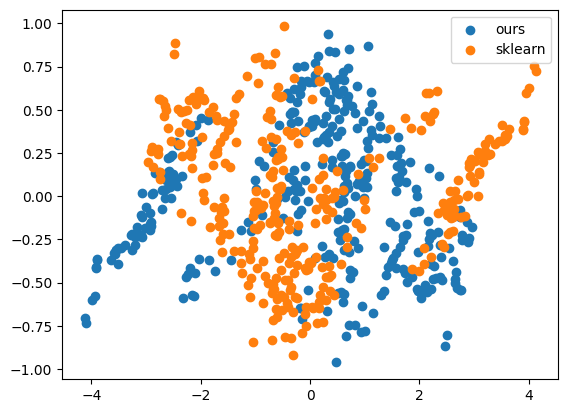

In [9]:
sk_pca = PCA(n_components=2)

sk_pca.fit(X)
print(sk_pca.explained_variance_ratio_)

sk_transformed = sk_pca.transform(X)
plt.scatter(x=transformed[:, 0], y=transformed[:, 1])
plt.scatter(x=sk_transformed[:, 0], y=sk_transformed[:, 1]+0.02)
plt.legend(['ours', 'sklearn'])


##### Преимущества и недостатки применения сингулярного и спектрального разложения к задачам PCA

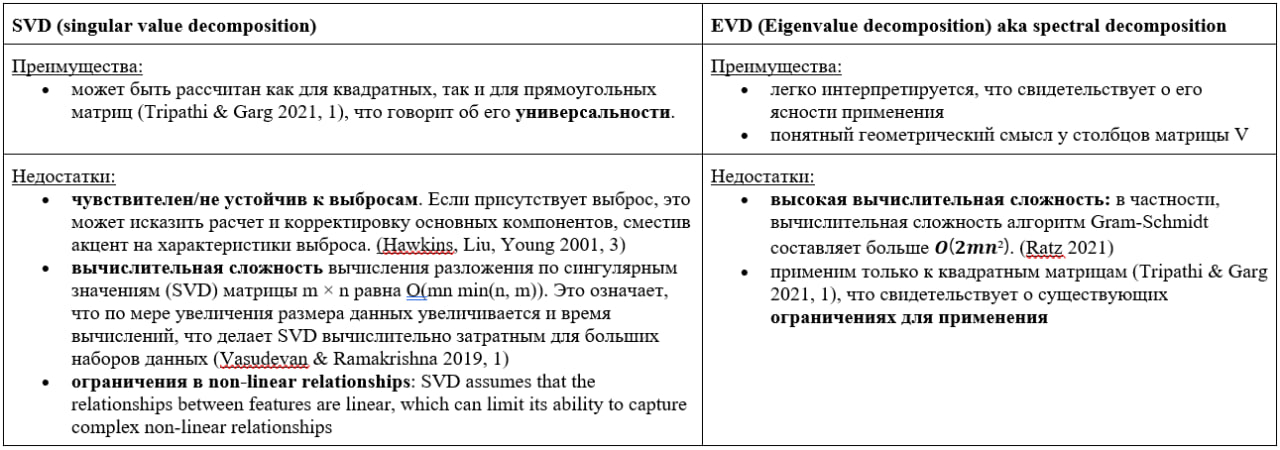

In [29]:
explained_variances = vars

##### Определение числа компонент, визуализация данных, анализ полученных компонент

In [25]:
cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_ratio = cumulative_explained_variance #/ np.sum(explained_variances)


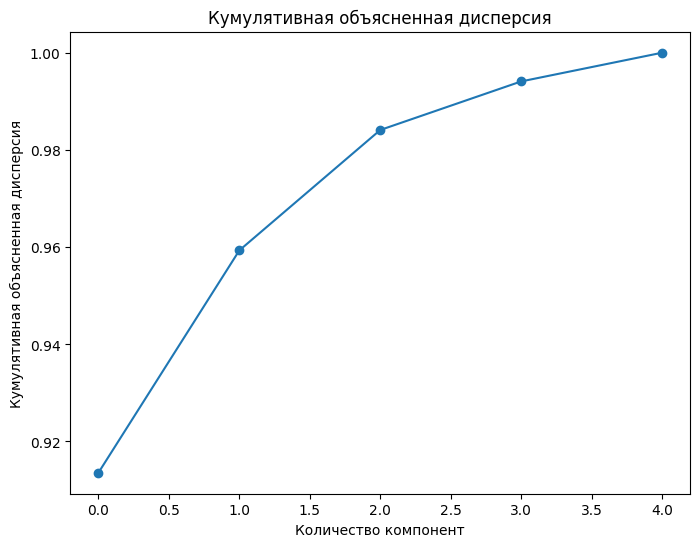

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Кумулятивная объясненная дисперсия')
plt.show()


In [31]:
data = pd.DataFrame(centred_data)
PCs = pd.DataFrame(transformed)
result = pd.concat([data, PCs], axis = 1)
result = pd.DataFrame(result)
result.columns = ['e_wbgi_vae', 'e_wbgi_cce', 'e_wbgi_gee', 'e_wbgi_rle', 'e_wbgi_rqe', 'PC1', 'PC2']
# calculate correlation matrix between variables and PC1
cor_matrix_PC1 = result[['e_wbgi_vae', 'e_wbgi_cce', 'e_wbgi_gee', 'e_wbgi_rle', 'e_wbgi_rqe', 'PC1']].corr()[['PC1']]# calculate correlation matrix between variables and PC2
cor_matrix_PC2 = result[['e_wbgi_vae', 'e_wbgi_cce', 'e_wbgi_gee', 'e_wbgi_rle', 'e_wbgi_rqe', 'PC2']].corr()[['PC2']]
# rename columnscor_matrix_PC1.columns = ['PC1']
cor_matrix_PC2.columns = ['PC2']
print("correlation tables")
print("Correlation matrix of variables with PC1:\n", cor_matrix_PC1)
print("Correlation matrix of variables with PC2:\n", cor_matrix_PC2)

ValueError: Length mismatch: Expected axis has 4 elements, new values have 7 elements

Дополнительно для анализа главных компонент и определения их значимости были найдены корреляции между представленными еи выбранными компонентами. График ранее показал, что PC1 описывает ~ 91% дисперсии данных, что уже является высоким показателем. Однако совместно со второй главной компонентной возможно объяснить свыше 96% данных. Для принятия решения по выбору одной или обоих главных компонент можно найти корреляцию между данными переменными и компонентами. 
 
Первая таблица показывает, что корреляция между e_wbgi_vae, e_wbgi_cce, e_wbgi_gee, e_wbgi_rle, e_wbgi_rqe и PC1, во-первых, отрицательная, и в среднем выше 0.9, что говорит о высокой коррелированности между переменными. Однако, нельзя сказать того же о PC2, где корреляция между переменными ближе к 0, чем к +-1. Таким образом, мы можем сделать вывод, что PC1 может считаться general evaluative dimension.

##### Дополнительное задание

### 2. Kernel PCA

##### Представление набора данных

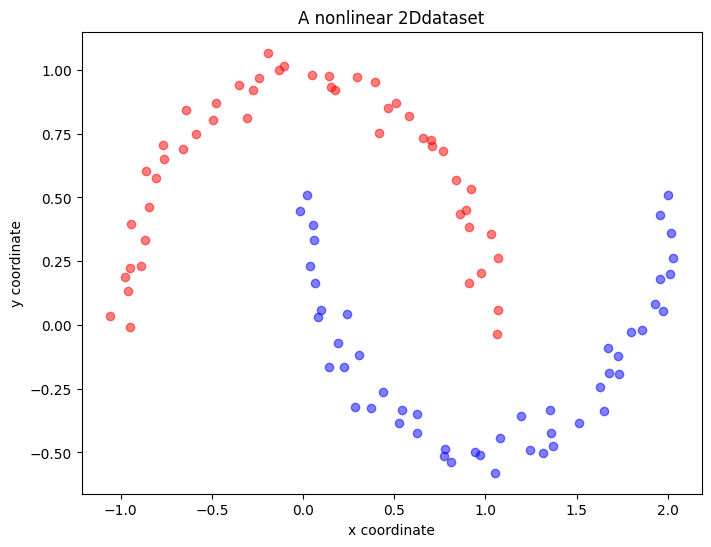

In [14]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123, noise=0.05)#.05)
moons_x, moons_y = X, y
plt.figure(figsize=(8, 6))

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()


In [15]:
mean_values = np.mean(moons_x, axis=0)
centred_data = moons_x - mean_values
moons_x = centred_data


#### Попробуем PCA. (Сравнительный анализ)

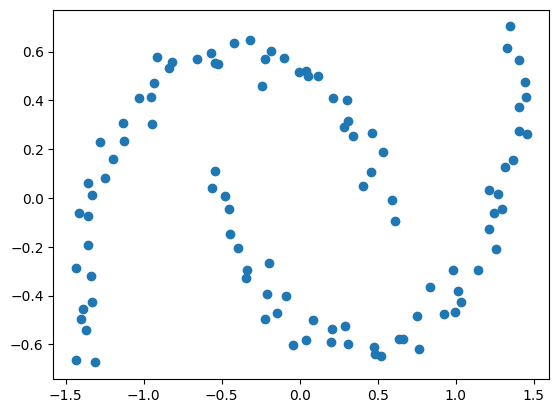

In [16]:
X = centred_data
pcs = get_pca(X)
t = X[0]  # first object
sum_distances_by_pc = defaultdict(int)
for pc_num, pc in enumerate(pcs.T):
    for obj in X:
        projection = pc@obj
        sum_distances_by_pc[pc_num] += projection**2


selected_pcs = pcs[:, :2]
transformed = X@selected_pcs
plt.scatter(x=transformed[:, 0], y=transformed[:, 1])

##### Вывод: PCA не справился с линейным разделением

##### Реализация методов вычисления матрицы для различных ядер  и её последующего спектрального разложения

In [17]:
def get_poly_kernel(x, c0, degree):  # relationship between columns
    feature_cnt = x.shape[1]
    ker = np.zeros((feature_cnt, feature_cnt))
    for f1 in range(feature_cnt):
        for f2 in range(f1, feature_cnt):
            ker[f1, f2] = (x[:, f1]@x[:, f2]+c0)**degree
            ker[f2, f1] = ker[f1, f2]
    return ker


def get_tanh_kernel(x, c0):
    feature_cnt = x.shape[1]
    ker = np.zeros((feature_cnt, feature_cnt))
    for f1 in range(feature_cnt):
        for f2 in range(f1, feature_cnt):
            ker[f1, f2] = np.tanh(x[:, f1]@x[:, f2]+c0)
            ker[f2, f1] = ker[f1, f2]
    return ker


def get_rbf_kernel(x, gamma):
    feature_cnt = x.shape[1]
    ker = np.zeros((feature_cnt, feature_cnt))
    for f1 in range(feature_cnt):
        for f2 in range(f1, feature_cnt):
            # print(x[:, f1]-x[:, f2])
            ker[f1, f2] = np.exp(-gamma*np.linalg.norm(x[:, f1]-x[:, f2])**2)
            ker[f2, f1] = ker[f1, f2]
    return ker

# get_poly_kernel(moons)


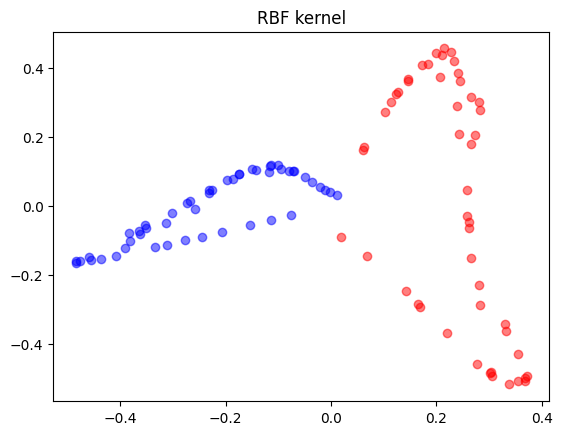

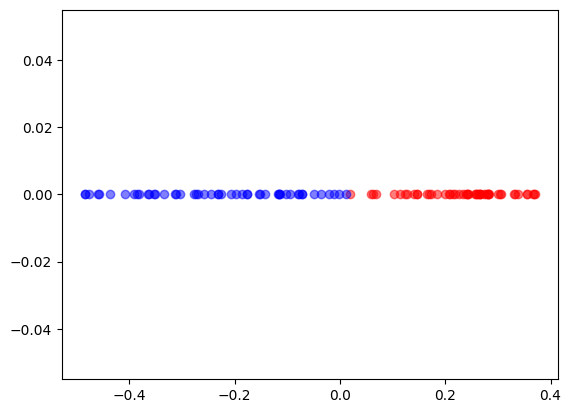

In [18]:
K = get_rbf_kernel(moons_x.T, gamma=15)
Kc = KernelCenterer().fit_transform(K)
K = Kc
eig_vals, pcs = get_kernel_pca(K, n_components=2)
transformed = K@pcs@np.diag((np.abs(eig_vals)**(-1/2)))# abs?
red_moon = transformed[moons_y == 0, :]
blue_moon = transformed[moons_y == 1, :]
plt.scatter(x=red_moon[:, 0], y=red_moon[:, 1], color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=blue_moon[:, 1], color='blue', alpha=0.5)
plt.title("RBF kernel")
plt.show()

plt.scatter(x=red_moon[:, 0], y=np.zeros_like(red_moon[:, 0]), color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=np.zeros_like(blue_moon[:, 0]), color='blue', alpha=0.5)


/home/serhio/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


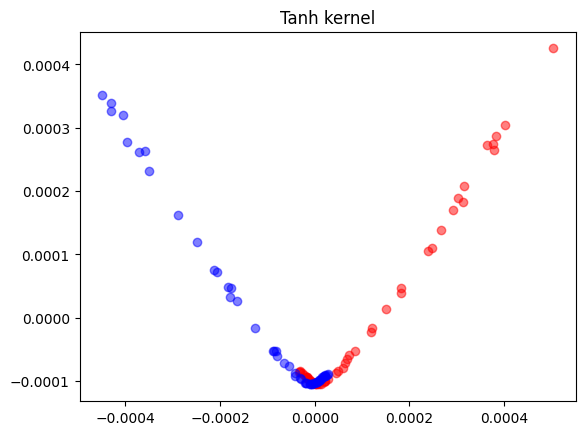

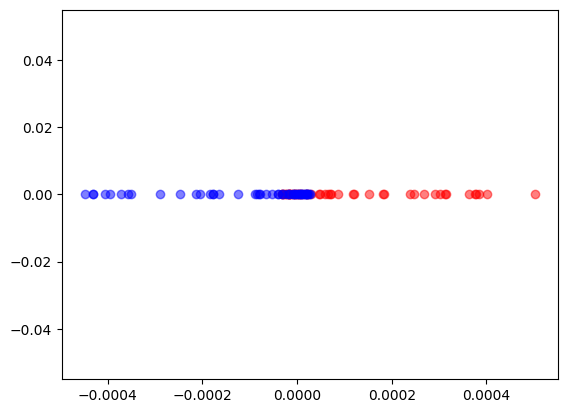

In [19]:
K = get_tanh_kernel(moons_x.T, c0=10)
Kc = KernelCenterer().fit_transform(K)
K = Kc
eig_vals, pcs = get_kernel_pca(K, n_components=2)
transformed = K@pcs@np.diag((np.abs(eig_vals)**(-1/2)))# abs?
red_moon = transformed[moons_y == 0, :]
blue_moon = transformed[moons_y == 1, :]
plt.scatter(x=red_moon[:, 0], y=red_moon[:, 1], color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=blue_moon[:, 1], color='blue', alpha=0.5)
plt.title("Tanh kernel")
plt.show()

plt.scatter(x=red_moon[:, 0], y=np.zeros_like(red_moon[:, 0]), color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=np.zeros_like(blue_moon[:, 0]), color='blue', alpha=0.5)


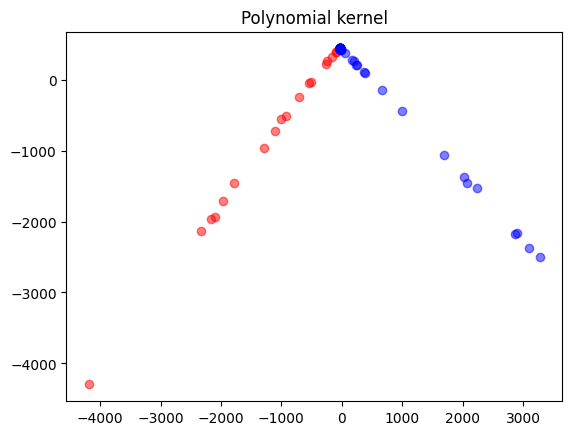

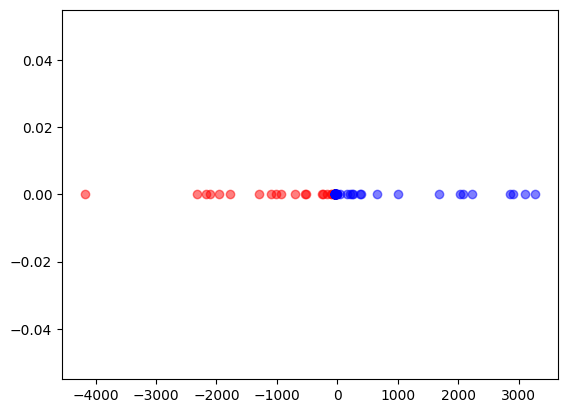

In [20]:
K = get_poly_kernel(moons_x.T, c0=1, degree=14)
Kc = KernelCenterer().fit_transform(K)
K = Kc
eig_vals, pcs = get_kernel_pca(K, n_components=2)
transformed = K@pcs@np.diag((np.abs(eig_vals)**(-1/2)))# abs?
red_moon = transformed[moons_y == 0, :]
blue_moon = transformed[moons_y == 1, :]
plt.scatter(x=red_moon[:, 0], y=red_moon[:, 1], color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=blue_moon[:, 1], color='blue', alpha=0.5)
plt.title("Polynomial kernel")

plt.show()

plt.scatter(x=red_moon[:, 0], y=np.zeros_like(red_moon[:, 0]), color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=np.zeros_like(blue_moon[:, 0]), color='blue', alpha=0.5)


Text(0.5, 1.0, 'Sklearn')

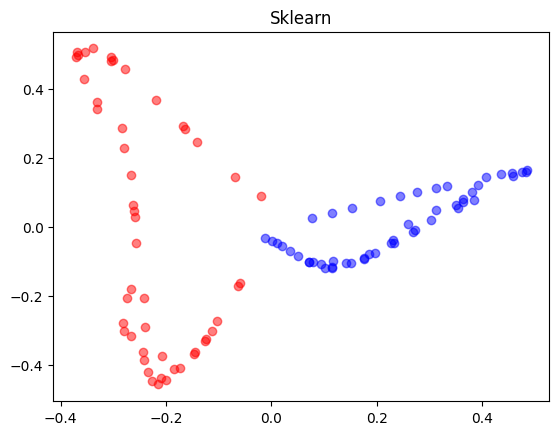

In [21]:
from sklearn.decomposition import KernelPCA

# sk_pca = KernelPCA(n_components=2, kernel='rbf', degree=2, coef0=1, gamma=1)
sk_pca = KernelPCA(n_components=2, kernel='rbf', gamma=15)

sk_pca.fit(moons_x)
# print(sk_pca.explained_variance_ratio_)

sk_transformed = sk_pca.transform(moons_x)
red_moon = sk_transformed[moons_y == 0, :]
blue_moon = sk_transformed[moons_y == 1, :]
plt.scatter(x=red_moon[:, 0], y=red_moon[:, 1], color='red', alpha=0.5)
plt.scatter(x=blue_moon[:, 0], y=blue_moon[:, 1], color='blue', alpha=0.5)
plt.title("Sklearn")
# plt.scatter(x=sk_transformed[:, 0], y=sk_transformed[:, 1]+0.2)


##### Сравнительный анализ применения PCA и Kernel PCA

Очевидно, RBF ядро позволило получить линейно разделимую выборку. В случае полиномиального ядра и тангенса есть пересечения.

References:

* Kaufmann, D. & Kraay, A. (2016), ‘Worldwide Governance Indicators’. URL: http://www.govindicators.org 
 
* Tripathi, P., & Garg, R.D. (2021). Comparative Analysis of Singular Value Decomposition and Eigen Value Decomposition Based Principal Component Analysis for Earth and Lunar Hyperspectral Image. 2021 11th Workshop on Hyperspectral Imaging and Signal Processing: Evolution in Remote Sensing (WHISPERS), 1-5. 
 
* Hawkins, D. M., Liu, L., & Young, S. S. (2001). (rep.). Robust Singular Value Decomposition (pp. 1–12). National Institute of Statistical Sciences. 
 
* Ratz, A. V. (2021). Can QR decomposition be actually faster? Schwarz-Rutishauser algorithm. Retrieved from https://towardsdatascience.com/can-qr-decomposition-be-actually-faster-schwarz-rutishauser-algorithm-a32c0cde8b9b?gi=5ee68e773b6e.